In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
q1=pd.read_csv('/content/drive/MyDrive/Q1_train.csv')
q1.head()

,datetime,ru_id,scgfail,scgfailratio,erabaddatt,erabaddsucc,endcaddatt,endcaddsucc,endcmodbymenbatt,endcmodbymenbsucc,...,bler_ul,bler_dl,rachpreamblea,numrar,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,uenomax
0,2023-05-19 00:00:00,BaseStationG,0,0.0,12,12,10,10,0,0,...,10.5,22.4,47.0,47.0,17.0,2243.0,-93.3,11.1,0,1
1,2023-05-19 00:00:00,BaseStationE,0,0.0,28,28,27,27,11,11,...,19.4,8.8,174.0,174.0,39.0,2240.0,-93.5,10.2,4,5
2,2023-05-19 00:00:00,BaseStationF,1,3.7,27,27,17,17,8,8,...,15.5,6.0,137.0,137.0,53.0,1337.0,-92.7,11.3,2,6
3,2023-05-19 00:00:00,BaseStationI,0,0.0,1,1,1,1,0,0,...,8.5,5.7,259.0,259.0,5.0,1401.0,-92.8,13.6,0,1
4,2023-05-19 00:00:00,BaseStationD,0,0.0,29,29,29,29,1,1,...,18.3,9.2,51.0,51.0,35.0,2083.0,-92.7,12.4,28,4


In [ ]:
print(q1.dtypes)

datetime                              datetime64[ns]
ru_id                                         object
scgfail                                        int64
scgfailratio                                 float64
erabaddatt                                     int64
erabaddsucc                                    int64
endcaddatt                                     int64
endcaddsucc                                    int64
endcmodbymenbatt                               int64
endcmodbymenbsucc                              int64
endcmodbysgnbatt                               int64
endcmodbysgnbsucc                              int64
connestabatt                                   int64
connestabsucc                                  int64
redirectiontolte_coverageout                   int64
redirectiontolte_epsfallback                   int64
redirectiontolte_emergencyfallback             int64
handoveratt                                    int64
handoversucc                                  

**dtype 맞게 전처리**

In [ ]:
#reestabatt, reestabsucc는 이미 int로 되어있음
q1['datetime'] = pd.to_datetime(q1['datetime'])

In [ ]:
is_missing = q1['rlculbyte'].isnull().any()
print(f"{'rlculbyte'} 열에 결측치 여부: {is_missing}")

rlculbyte 열에 결측치 여부: True


**비율=연결 성공한 횟수/연결 시도한 횟수**

In [ ]:
q1['erabaddratio'] = q1['erabaddsucc'] / q1['erabaddatt'].replace(0, 1)
q1['endcaddratio'] = q1['endcaddsucc'] / q1['endcaddatt'].replace(0, 1)
q1['endcmodbymenbratio'] = q1['endcmodbymenbsucc'] / q1['endcmodbymenbatt'].replace(0, 1)
q1['endcmodbysgnbratio'] = q1['endcmodbysgnbsucc'] / q1['endcmodbysgnbatt'].replace(0, 1)
q1['connestabratio'] = q1['connestabsucc'] / q1['connestabatt'].replace(0, 1)
q1['handoverratio'] = q1['handoversucc'] / q1['handoveratt'].replace(0, 1)
q1['reestabratio'] = q1['reestabsucc'] / q1['reestabatt'].replace(0, 1)

In [ ]:
#기존 성공한 횟수 변수는 삭제
q1 = pd.DataFrame(q1)
df = q1.drop(['erabaddsucc','endcaddsucc','endcmodbymenbsucc','endcmodbysgnbsucc','connestabsucc','handoversucc','reestabsucc'],axis = 1)

In [ ]:
q1.info()

**상관계수 확인**

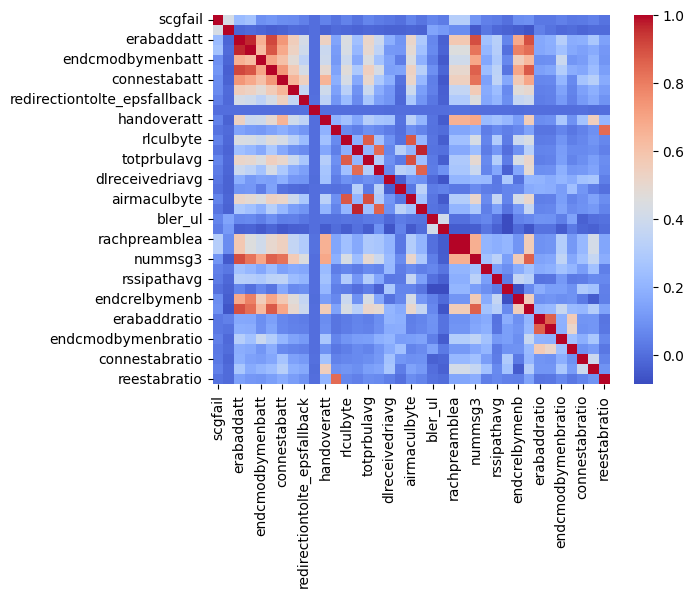

In [ ]:
# 수치형 변수만 선택
numeric_vars = df.select_dtypes(include='number')

corr = numeric_vars.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

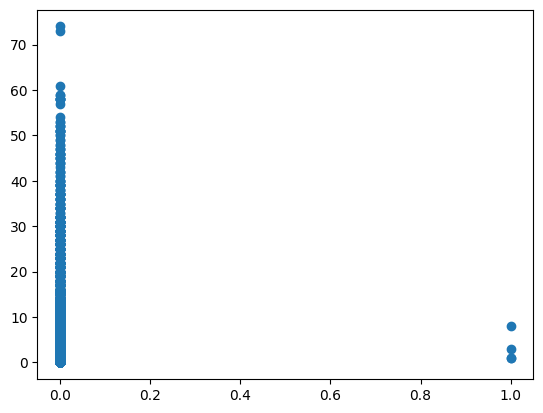

In [ ]:
#비선형성이 있는지 산점도로 확인-> emergency가 0이 너무 많
plt.scatter(df['redirectiontolte_emergencyfallback'], df['uenomax'])
plt.show()

In [ ]:
#y와 상관계수가 0인 변수 삭제
df = df.drop(['redirectiontolte_emergencyfallback'],axis = 1)

**rachpreamblea, numrar 데이터 동일 → 둘 중 하나 drop**

In [ ]:
#진짜 동일한가?
are_equal = (df['rachpreamblea'] == df['numrar']).all()

if are_equal:
    print('True')
else:
    print('False')

False


In [ ]:
#결측값때문에 False로 나오는거같음 삭제했더니 같다고함
#근데 만약 결측값을 보간법으로 채우면 두변수는 달라지는거라 삭제하면안됨!

df1 = df.dropna()

different_rows = df1[df1['rachpreamblea'] != df1['numrar']]
if different_rows.empty:
    print("Equal")
else:
    print(different_rows[['rachpreamblea','numrar']])

Equal


In [ ]:
df = df.drop(['rachpreamblea'],axis = 1)

**선형 보간법**

In [ ]:
# 결측치 전후의 패턴이 변화하는 구간인 경우에는
# 직전값, 직후값, 평균/중앙값 같은 방식으로 처리할 경우 문제가 발생
# 선형 보간법 사용해보겠음!

In [ ]:
from scipy import interpolate

In [ ]:
missing_rows = df[df['rlculbyte'].isna()]
missing_rows

,datetime,ru_id,scgfail,scgfailratio,erabaddatt,endcaddatt,endcmodbymenbatt,endcmodbysgnbatt,connestabatt,redirectiontolte_coverageout,...,dlreceivedcqiavg,endcrelbymenb,uenomax,erabaddratio,endcaddratio,endcmodbymenbratio,endcmodbysgnbratio,connestabratio,handoverratio,reestabratio
43864,2023-06-07 00:55:00,BaseStationG,0,0.0,9,6,1,3,4,0,...,NaN,1,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
43865,2023-06-07 00:55:00,BaseStationE,0,0.0,18,12,0,13,2,0,...,NaN,1,4,1.0,1.0,0.0,1.0,1.0,0.0,0.0
43866,2023-06-07 00:55:00,BaseStationF,0,0.0,16,8,1,11,13,0,...,NaN,1,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0
96845,2023-06-30 00:55:00,BaseStationG,0,0.0,29,24,1,14,4,0,...,NaN,1,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
96846,2023-06-30 00:55:00,BaseStationE,0,0.0,21,17,8,16,0,0,...,NaN,1,4,1.0,1.0,1.0,1.0,0.0,0.0,0.0
96847,2023-06-30 00:55:00,BaseStationF,1,3.8,26,19,3,19,10,0,...,NaN,1,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
117573,2023-07-09 00:55:00,BaseStationG,0,0.0,16,6,0,19,0,0,...,NaN,0,3,1.0,1.0,0.0,1.0,0.0,1.0,0.0
117574,2023-07-09 00:55:00,BaseStationE,1,4.3,23,22,2,12,2,0,...,NaN,2,4,1.0,1.0,1.0,1.0,1.0,0.0,0.0
117575,2023-07-09 00:55:00,BaseStationF,1,2.9,34,28,1,19,5,0,...,NaN,1,9,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
df['rlculbyte'] = df['rlculbyte'].interpolate(method='linear')
df['rlcdlbyte'] = df['rlcdlbyte'].interpolate(method='linear')
df['totprbulavg'] = df['totprbulavg'].interpolate(method='linear')
df['totprbdlavg'] = df['totprbdlavg'].interpolate(method='linear')
df['dlreceivedriavg'] = df['dlreceivedriavg'].interpolate(method='linear')
df['dltransmittedmcsavg'] = df['dltransmittedmcsavg'].interpolate(method='linear')
df['airmaculbyte'] = df['airmaculbyte'].interpolate(method='linear')
df['airmacdlbyte'] = df['airmacdlbyte'].interpolate(method='linear')
df['bler_ul'] = df['bler_ul'].interpolate(method='linear')
df['bler_dl'] = df['bler_dl'].interpolate(method='linear')
df['rachpreamblea'] = df['rachpreamblea'].interpolate(method='linear')
df['numrar'] = df['numrar'].interpolate(method='linear')
df['nummsg3'] = df['nummsg3'].interpolate(method='linear')
df['attpaging'] = df['attpaging'].interpolate(method='linear')
df['rssipathavg'] = df['rssipathavg'].interpolate(method='linear')
df['dlreceivedcqiavg'] = df['dlreceivedcqiavg'].interpolate(method='linear')

KeyError: ignored